# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [297]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec
import hashlib
import os

# Load pickled data
import pickle

import csv as csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
import numpy as np
from PIL import Image
from IPython.display import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from zipfile import ZipFile
import pickle
from skimage import color
import pandas as pd

# Visualizations will be shown in the notebook.
%matplotlib inline

print('All modules imported.')

All modules imported.


In [298]:
# TODO: Fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [299]:
X_train.shape

(39209, 32, 32, 3)

In [300]:
X_test.shape

(12630, 32, 32, 3)

In [301]:
X_train.shape[0]
len(X_train)

39209

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [302]:
### Replace each question mark with the appropriate value.
import numpy as np


# TODO: Number of training examples
#n_train = X_train.shape[0]
n_train = len(X_train)

# TODO: Number of testing examples.
#n_test = X_test.shape[0]
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes1 = len(set(y_train))
n_classes = len(np.unique(y_train))

assert n_classes1 == n_classes
print("The result is ok")

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

The result is ok
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

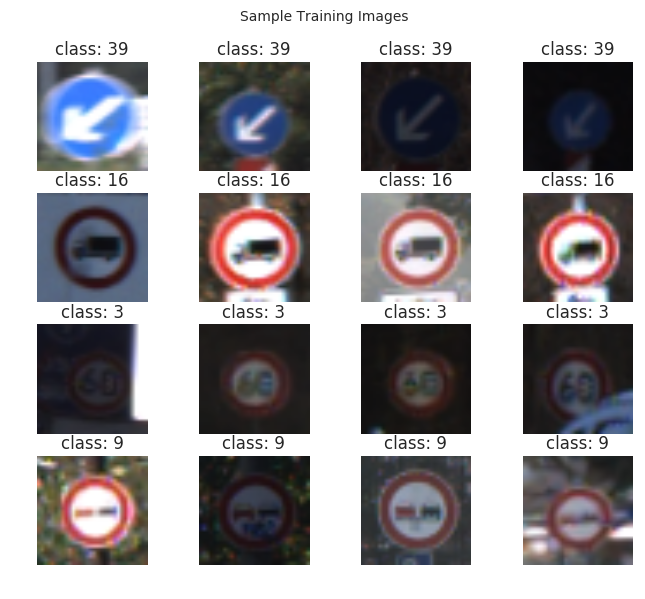

In [303]:


def display_images(image_dataset, n_rows, n_cols, graph_title='Sample Training Images'):
    '''
    Simple utility function for displaying images.
    '''
    plt.figure(figsize=(8, 6.5))
    selected_classes = np.random.randint(44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        for col in range(1, n_cols + 1):
            plt.subplot(n_rows, n_cols, image_number)
            image_number += 1
            x_selected = X_train[y_train == row]
            random_index = np.random.randint(x_selected.shape[0])
            plt.imshow(x_selected[random_index, :, :, :]) 
            plt.axis('off')
            plt.title('class: {}'.format(row))  
    plt.suptitle(graph_title)
    plt.show()
    

display_images(X_train, 4, 4)

### Distribution of traffic signs

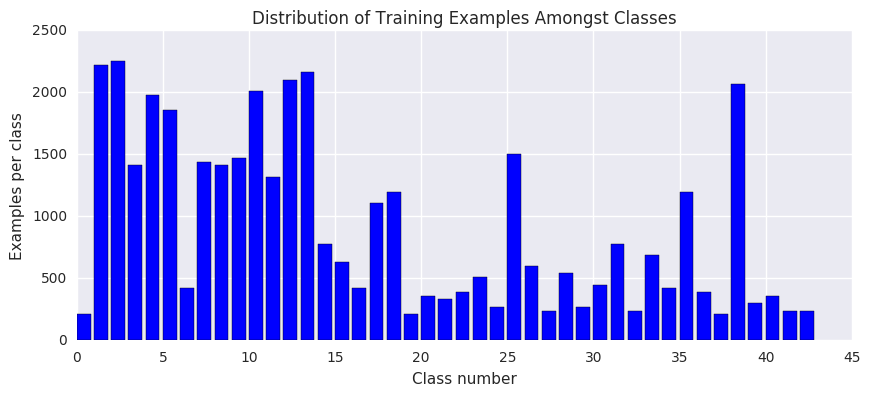

(39209, 32, 32, 3)
(39209,)


In [304]:
def draw_class_distribution(class_labels):
    '''This function is used to plot the distribution of training examples amongst classes.'''
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8, color='blue', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show() 
    
draw_class_distribution(y_train)
print(X_train.shape) 
print(y_train.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Helper functions 

In [305]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pickle


class DataSet:
    def __init__(self, X, y):
        self.X = X
        self.y = y

        self.pointer = 0
        self.dataset_length = len(y)

    def next_batch(self, size):
        next_indices = np.arange(self.pointer, self.pointer + size) % self.dataset_length
        self.pointer += size
        self.pointer = self.pointer % self.dataset_length

        return self.X[next_indices], self.y[next_indices]

    def length(self):
        return self.dataset_length


def train_valid_split(X, y, test_size):
    train_features, valid_features, train_labels, valid_labels = train_test_split(X,
                                                                              y,
                                                                              test_size=test_size,
                                                                              random_state=1024)
    return train_features, valid_features, train_labels, valid_labels


def one_hot_encoding(y_train, y_test):
    labelBinarizer = LabelBinarizer()
    labelBinarizer.fit(y_train)

    y_train_one_hot = labelBinarizer.transform(y_train)
    y_test_one_hot = labelBinarizer.transform(y_test)
    return y_train_one_hot, y_test_one_hot


def center_normalization(X_train, X_test):
    x_train = X_train.astype(np.float32)
    x_train -= np.mean(x_train, axis=0)
    x_train /= np.std(x_train, axis=0)

    x_test = X_test.astype(np.float32)
    x_test -= np.mean(x_test, axis=0)
    x_test /= np.std(x_test, axis=0)

    return x_train, x_test


def min_max_normalization(data, a=-0.5, b=0.5):
    data_max = np.max(data)
    data_min = np.min(data)
    return a + (b - a) * ((data - data_min) / (data_max - data_min))


def conv2d(X, W, b, stride=1):
    X = tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME')
    X = tf.nn.bias_add(X, b)
    X = tf.nn.relu(X)
    return X


def maxpool2d(X, k=2):
    return tf.nn.max_pool(
        X, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME'
    )


def plot_learning_curves(training_losses, training_accuracies, valid_losses, valid_accuracies):
    import seaborn as sbs;
    sbs.set()
    epochs = np.arange(len(training_losses))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, training_losses, color='blue', linewidth=2.0, label='training')
    plt.plot(epochs, valid_losses, color='green', linewidth=2.0, label='validation')

    # plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, training_accuracies, color='blue', linewidth=2.0, label='training')
    plt.plot(epochs, valid_accuracies, color='green', linewidth=2.0, label='validation')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.savefig('learning_curves.jpg')
    plt.show()

# Generating additional data by jittering the original image
def transform_image(img, ang_range, shear_range, trans_range):
    '''
    NOTE: this method was given credit to Vivek Yadav
    https://github.com/vxy10/ImageAugmentation
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)

    # Translation
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_M = cv2.getAffineTransform(pts1, pts2)

    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))

    return img

In [306]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
VALID_PERCENTAGE = 0.2

# Mix-Max Normalization
X_train_maxmin = min_max_normalization(X_train)
X_test_maxmin = min_max_normalization(X_test)

# One-Hot-Encoding
y_train, y_test = one_hot_encoding(y_train, y_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_
  

**Answer:**
For Data Images Preprocessing for DNN, the following steps are generally done:

- Same Size Images: All images are converted to the same size and generally in square shape.
- Mean Centering: For each pixel, its mean value among all images can be subtracted from each pixel.

So here are some steps for preprocessing data :

1. First, Normalization of data is one of the most important steps in prepropcessing data which is intended for faster approaching to global minima at error surface. I use `Min-Max Normalization` instead of `Mean Centering` for preprocessing stage.

2. Secondly, Converting labels to vectors by using One hot encoding. 

3. Next, Shuffling to randomize the input for each epoch.

4. Finally, Generating data batches using Dataset class in helper functions

In [307]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Step: 3 train and valid split
train_features, dev_features, train_labels, dev_labels = train_valid_split(
    X_train_maxmin, y_train, VALID_PERCENTAGE)

training_dataset = DataSet(train_features, train_labels)
valid_dataset = DataSet(dev_features, dev_labels)
testing_dataset = DataSet(X_test_maxmin, y_test)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The original training/testing datasets are splitted from normalized dataset. In this project, validation dataset is extracted from 20% of original training dataset. From the visualization of dataset, we can find that data is imbalanced that is easily led to bias in our model. So we need to generate optional dataset (augmented dataset) to handle with this issue. 

In [308]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Hyperparameter
N_CLASSES = 43

TRAINING_FILE = './data/train.p'
TESTING_FILE = './data/test.p'

MODEL_NAME = './checkpoint_lenet/LeNet.ckpt'

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
     
    #Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')#Input = 10x10x16. Output = 5x5x16.
        
        
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal((fc1.get_shape().as_list()[-1], 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b 
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    

    #Layer 4: Fully Connected. Input = 1024. Output = 1024.
    fc2_W = tf.Variable(tf.truncated_normal((1024, 512), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(512))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b 
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    
    # Layer 5: Fully Connected. Input = 1024. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal((512, N_CLASSES), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(N_CLASSES))
    logits = tf.matmul(fc2, fc3_W) + fc3_b 
    
    return logits, [conv1_W, conv2_W, fc1_W, fc2_W, fc3_W] 
    

### L2 - Regularization cost function

In [309]:
def regularization_cost(weights, regularization):
    reg_cost = 0.0
    for weight in weights:
        reg_cost += regularization * tf.nn.l2_loss(weight)
    return reg_cost


### Features and Labels
Train LeNet to classify Traffic sign data.
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [310]:
# placeholders for input images, labels and dropout percentage
x = tf.placeholder("float", [None, 32, 32, 3])
tf.add_to_collection("x", x)  # Remember this Op.

y = tf.placeholder("float", [None, NUM_CLASSES])
tf.add_to_collection("y", y) 

keep_prob = tf.placeholder(tf.float32)
tf.add_to_collection("keep_prob", keep_prob)

### Training Pipeline
Create a training pipeline that uses the model to classify traffic sign data.


In [311]:
LEARNING_RATE = 1e-3
REGULARIZATION_PARAM = 1e-6

logits, weights = LeNet(x)
tf.add_to_collection("logits", logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
loss_operation = tf.reduce_mean(cross_entropy) + regularization_cost(weights, REGULARIZATION_PARAM)
tf.add_to_collection('loss_operation', loss_operation)

optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.



In [312]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.add_to_collection('accuracy_operation', accuracy_operation)

saver = tf.train.Saver()


def evaluate(dataset):
    steps_per_epoch = dataset.length() // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_accuracy, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = dataset.next_batch(BATCH_SIZE)
        loss, accuracy = sess.run([loss_operation, accuracy_operation], 
                             feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

### Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

Epoch:0 train loss:0.6232 valid loss:0.5005 train accu:0.8359 valid accu:0.8714
Epoch:20 train loss:0.0068 valid loss:0.0446 train accu:1.0000 valid accu:0.9928
Epoch:40 train loss:0.0073 valid loss:0.0469 train accu:1.0000 valid accu:0.9937
Epoch:60 train loss:0.0093 valid loss:0.0444 train accu:1.0000 valid accu:0.9945
Epoch:80 train loss:0.0100 valid loss:0.0602 train accu:1.0000 valid accu:0.9947
Trained model saved to the disk.


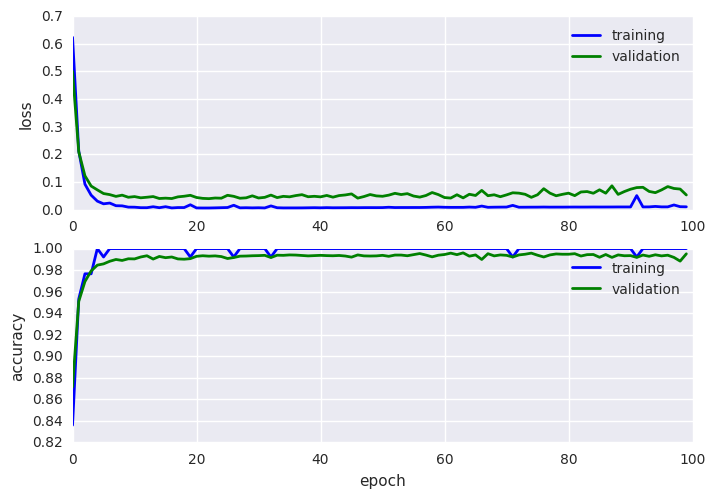

In [314]:
EPOCHS = 100
BATCH_SIZE = 128
best_valid_accuracy = 1e-10


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(train_features) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    
    training_accuracies = []
    valid_accuracies = []

    training_losses = []
    valid_losses = []
    
    for epoch in range(EPOCHS):
        
        for step in range(steps_per_epoch):
            batch_x, batch_y = training_dataset.next_batch(BATCH_SIZE)
            loss, accuracy = sess.run([training_operation, accuracy_operation],
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})        
        
        # training loss and accuracy after an epoch
        train_loss, train_acc = sess.run([loss_operation, accuracy_operation], 
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})        
        training_losses.append(train_loss)
        training_accuracies.append(train_acc)

        
        valid_loss, valid_acc = evaluate(valid_dataset)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        
        
        if valid_acc > best_valid_accuracy:                
                saver.save(sess, MODEL_NAME, global_step=step)
                best_valid_accuracy = valid_acc
        
        if epoch % 20 == 0:
            print('Epoch:{:d} train loss:{:.4f} valid loss:{:.4f} train accu:{:.4f} valid accu:{:.4f}'.format(
                    epoch, train_loss,  valid_loss,  train_acc, valid_acc))      
    
    print('Trained model saved to the disk.')
    plot_learning_curves(training_losses, training_accuracies, valid_losses, valid_accuracies )

### Evaluate the Model

Now it's time to evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [315]:
with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph('./checkpoint_lenet/LeNet.ckpt-244.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_lenet'))
        
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logits = tf.get_collection('logits')[0]
    accuracy_operation = tf.get_collection('accuracy_operation')[0]
    loss_operation = tf.get_collection('loss_operation')[0]
        
    model_loss, model_perf = evaluate(testing_dataset)
    print('Test Dataset Classification Accuracy: {:.4f}'.format(model_perf))

Test Dataset Classification Accuracy: 0.9517


### Generate additional data

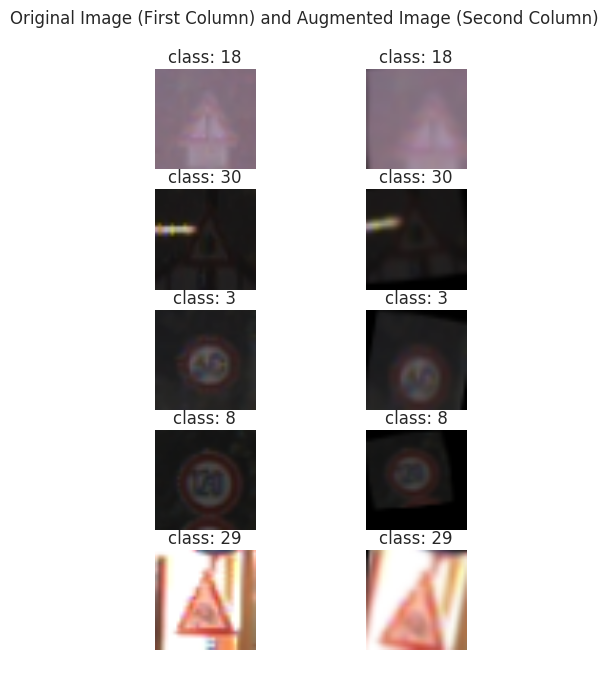

In [316]:
def display_augmented_images(image_dataset, augmented_data, n_rows):
    '''
    Simple utility function for displaying augmented images.
    '''
    plt.figure(figsize=(5,7.5))
    selected_classes = np.random.randint(0, 44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        x_selected = X_train[np.argmax(y_train, axis=1) == row]
        index = 0 # print first image of each image category
        
        plt.subplot(n_rows, 2, image_number)
        plt.imshow(x_selected[index, :, :, :]) 
        plt.axis('off')
        plt.title('class: {}'.format(row)) 
        image_number += 1
        
        aug_selected = augmented_data[np.argmax(y_train, axis=1) == row]
        
        plt.subplot(n_rows, 2, image_number)
        plt.imshow(aug_selected[index, :, :, :]) 
        plt.axis('off')
        plt.title('class: {}'.format(row))
        image_number += 1
        
    plt.suptitle('Original Image (First Column) and Augmented Image (Second Column)')
    plt.show()
    
    
X_train_transformed = np.zeros_like(X_train)
y_train_transformed = np.zeros_like(y_train)

for i in range(X_train_transformed.shape[0]): #
    X_train_transformed[i] = transform_image(X_train[i], 20, 10, 5)
    y_train_transformed[i] = y_train[i]        

display_augmented_images(X_train, X_train_transformed, 5)

In [317]:
X_train_transformed.shape
#X_train.shape
#draw_class_distribution(y_train_transformed)

y_train_transformed.shape

(39209, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(train_features) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    
    training_accuracies = []
    valid_accuracies = []

    training_losses = []
    valid_losses = []
    
    for epoch in range(EPOCHS):
        
        for step in range(steps_per_epoch):
            batch_x, batch_y = training_dataset.next_batch(BATCH_SIZE)
            loss, accuracy = sess.run([training_operation, accuracy_operation],
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})        
        
        # training loss and accuracy after an epoch
        train_loss, train_acc = sess.run([loss_operation, accuracy_operation], 
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})        
        training_losses.append(train_loss)
        training_accuracies.append(train_acc)

        
        valid_loss, valid_acc = evaluate(valid_dataset)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        
        
        if valid_acc > best_valid_accuracy:                
                saver.save(sess, 'lenet', global_step=step)
                best_valid_accuracy = valid_acc
        
        if epoch % 20 == 0:
            print('Epoch:{:d} train loss:{:.4f} valid loss:{:.4f} train accu:{:.4f} valid accu:{:.4f}'.format(
                    epoch, train_loss,  valid_loss,  train_acc, valid_acc))      
    
    print('Trained model saved to the disk.')
    plot_learning_curves(training_losses, training_accuracies, valid_losses, valid_accuracies )

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

 My final architecture of DNN is:
 
 - Convolutional Layer 1: Input = 32x32x3, Output = 28x28x6, Filter size = 5x5 kernel, stride = 1, depth = 6, padding = VALID.

- Max pooling layer: Input = 28x28x6, Output = 14x14x6, filter size = 2x2 kernel, stride = 2

- Convolutional Layer 2: Input = 14x14x6, Output = 10x10x16, Filter size = 5x5 kernel, stride = 1, depth = 16, padding = VALID .

- Max pooling layer: Input = 10x10x16, Output = 5x5x16, Filter size =  2x2 kernel, stride = 2

- Fully connected layer with size = 1024

- Dropout layer with dropout probability 0.5

- Fully connected layer with size = 1024

- Dropout layer with dropout probability 0.5

- Finally, a softmax layer with size 43

In [318]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Learning Model:

- Optimizer = AdamOptimizer

- Learning Rate = $10^{-3}$

- Epochs = 100

- Batch Size = 128

- Regularization Parameter = $10^{-6}$

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

LeNet architecture is a very reputed model for computer vision task. For that reason, I implemented different versions of this DNN architecture in terms of various deep layers, learning rate, epoch or fully connected layer. The performance of this model is rather good for validation dataset (99%) and testing dataset (95%).

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

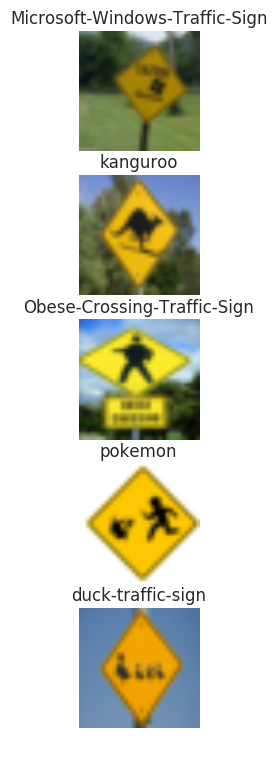

In [333]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
import scipy.misc

NEW_IMAGES_FOLDER = './new_traffic_sign/'

labels = {0: 'microsoft windows',
          1: 'kanguroo',
          2: 'obese crossing',
          3: 'pokemon chasing',
          4: 'duck crossing'}

def resize_image(image_file):
    image = plt.imread(NEW_IMAGES_FOLDER + image_file)
    return scipy.misc.imresize(image, (32, 32))

resized_image_data = [(resize_image(image), image[:-4]) 
                          for image in os.listdir(NEW_IMAGES_FOLDER)]



def display_images(imgs_data):
    index = 1
    plt.figure(figsize=(4,9))
    for img, name in imgs_data:
        plt.subplot(len(resized_image_data), 1, index)
        plt.imshow(img)
        plt.axis('off')
        plt.title(name)
        index += 1
    plt.show()
    
display_images(resized_image_data)

In [336]:
resized_image_data[0][0].shape
resized_image_data[1][0].shape
resized_image_data[2][0].shape
resized_image_data[3][0].shape
resized_image_data[4][0].shape

(32, 32, 3)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

My new traffic signs are randomly selected from the internet. They are not similar in the training dataset and their sizes are inconsistent so CNNs can not classify those signs correctly but it can gives us a meaning prediction of those signs. 

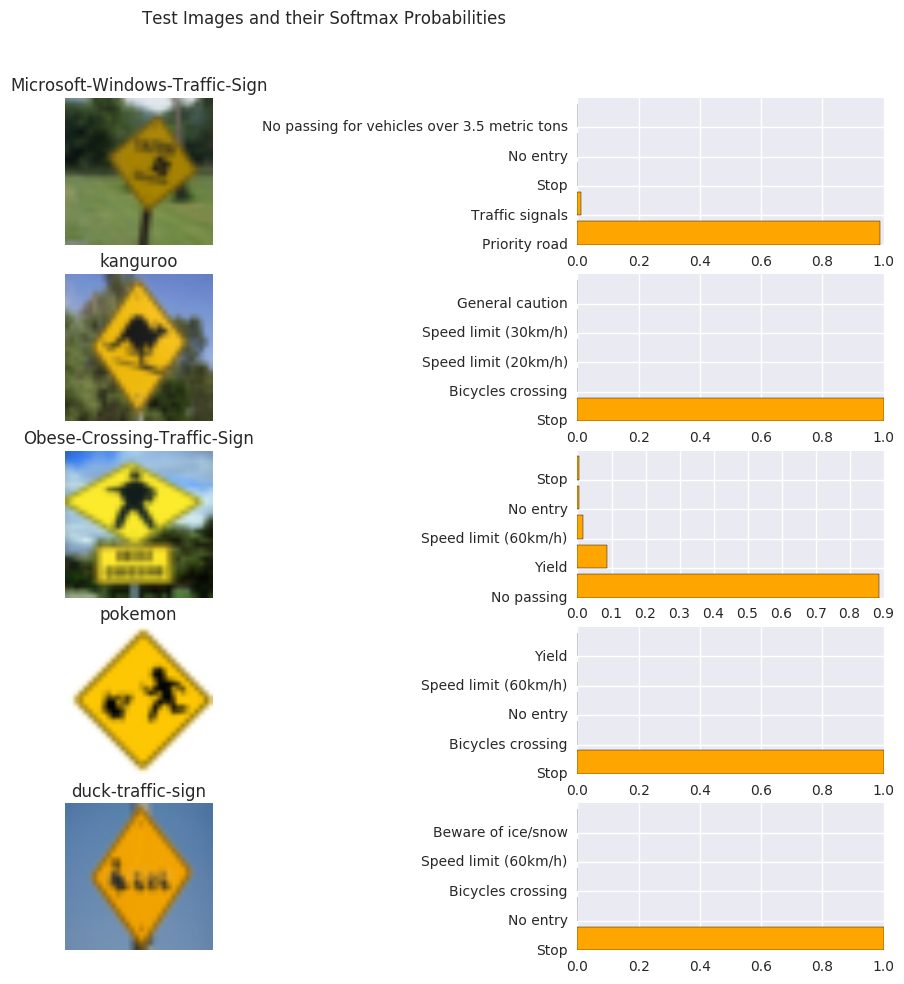

In [344]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

resized_images = [img_and_name[0] for img_and_name in resized_image_data]
X_test_new_dataset = min_max_normalization(np.array(resized_images))


def print_result(ground_truth, top_k_prob, top_k_indices):
    class_names = pd.read_csv('./signnames.csv')['SignName'].values
    index = 0
    img_index = 0
    plt.figure(figsize=(14, 11))
    gs = gridspec.GridSpec(5, 2, width_ratios=[1, 0.45]) 
    for key in ground_truth:
        img, tag = resized_image_data[img_index]
        img_index += 1
        plt.subplot(gs[index])
        plt.imshow(img)
        plt.axis('off')
        plt.title(tag)
        index += 1

        plt.subplot(gs[index])
        plt.barh(np.arange(1, 6, 1), 
                 top_k_prob[key, :],
                 0.8, 
                 color='orange')
        plt.yticks(np.arange(1, 6, 1), class_names[top_k_indices[key, :]])
        index += 1
    plt.suptitle('Test Images and their Softmax Probabilities')
    plt.show()
    
    

with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph('./checkpoint_lenet/LeNet.ckpt-244.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_lenet'))
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logits = tf.get_collection('logits')[0]
    softmax = tf.nn.softmax(logits)
    normalized_prob = sess.run(softmax, feed_dict={x: X_test_new_dataset, keep_prob: 1.0})    
    top_k_op = tf.nn.top_k(normalized_prob, k=5)
    top_k_results = sess.run(top_k_op)
    
    # show predictions with their probabilities
    print_result(labels, top_k_results.values, top_k_results.indices)




### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

By looking at the softmax probability of 5 new traffic signs, we can easily check that CNNs failed to predict all unfamiliar signs. For example, kangaroo and duck signs are supposed to classifed as wild animals crossing sign but both are predicted as Stop sign. I think one of the roots of this misclassification is that we did not provide larger dataset enough for CNNs to learn and generate higher and more sensible guesses.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

 According to the visualization of top 5 probabilities of softmax Model, in all five cases, CNN model makes its first choice with the highest probability and other four choices are almost negligible. But none of them is correct so thie model is rather uncertain for a small new dataset.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Reference

`Dealing with unbalanced data: Generating additional data by jittering the original image`
https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.q8s9ztq6a